# GenerativeAI4DS-I
## Lab. Image Understanding

##  What I hope you'll get out of this lab
* The feeling that you'll "know where to start" when you have to consume OpenAI services.
* Follow OpenAI's best practices on how to process audio and video

In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00


In [2]:
from IPython.display import display, Image, Audio, HTML

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

In [3]:
def show_json(obj):
    display(json.loads(obj.model_dump_json()))

In [4]:
# We need this to load the files onto google colab
!git clone https://github.com/thousandoaks/GenerativeAI4DS-I.git

Cloning into 'GenerativeAI4DS-I'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 89 (delta 30), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (89/89), 3.17 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (30/30), done.


# 1. You have to get your [OpenAI API Key](https://platform.openai.com/account/api-keys)

In [5]:
# Used by the agent in this tutorial
os.environ["OPENAI_API_KEY"] = "YOU-NEED-YOUR-OWN_KEY"

In [6]:
client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY'],  # this is also the default, it can be omitted
)

# 2. Image Understanding
OpenAI has multimedia processing capabilities. In this example we will interpret the information contained in an image to extract information about the employees, their roles, and their managers from the image. We will use function/tool calling to specify the input parameters for the organizational structure, such as the employee name, role, and manager's name and role.


### 2.1. Image Loading
#### First, we load the image from a local repository

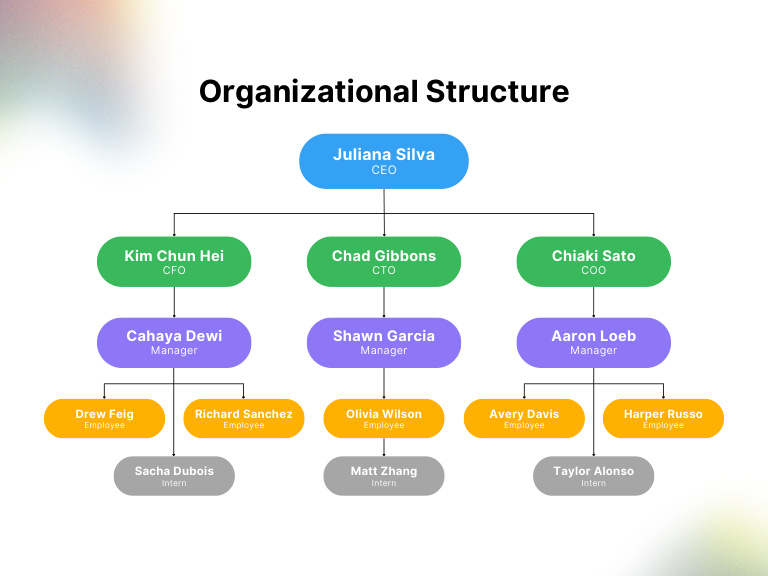

In [11]:
display(Image('/content/GenerativeAI4DS-I/datasets/organigram.jpeg'))

In [9]:
# Function to encode the image as base64
def encode_image(image_path: str):
    # check if the image exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [10]:
base64_img = encode_image('/content/GenerativeAI4DS-I/datasets/organigram.jpeg')


### 2.2. Image Processing (First Attempt)
#### Once we have the image ready, we craft our prompt and send a request to GPT

In [15]:
response = client.chat.completions.create(

    model="gpt-4o",
    messages=[

        {"role": "user", "content": [
            {"type": "text", "text": "Analyze the given organizational chart and very carefully extract the information."},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_img}"}
            }
        ]}
    ],
    temperature=0.0,
)

print(response.choices[0].message.content)





The organizational chart provided outlines the structure of the company, detailing the hierarchy and reporting relationships among the employees. Here is the extracted information:

1. **Juliana Silva** - CEO
   - **Kim Chun Hei** - CFO
     - **Cahaya Dewi** - Manager
       - **Drew Feig** - Employee
       - **Richard Sanchez** - Employee
         - **Sacha Dubois** - Intern
   - **Chad Gibbons** - CTO
     - **Shawn Garcia** - Manager
       - **Olivia Wilson** - Employee
         - **Matt Zhang** - Intern
   - **Chiaki Sato** - COO
     - **Aaron Loeb** - Manager
       - **Avery Davis** - Employee
       - **Harper Russo** - Employee
         - **Taylor Alonso** - Intern

### Summary:
- **CEO**: Juliana Silva
- **CFO**: Kim Chun Hei
  - **Manager**: Cahaya Dewi
    - **Employees**: Drew Feig, Richard Sanchez
      - **Intern**: Sacha Dubois (under Richard Sanchez)
- **CTO**: Chad Gibbons
  - **Manager**: Shawn Garcia
    - **Employee**: Olivia Wilson
      - **Intern**: Matt Zhan

In [17]:
display(HTML(response.choices[0].message.content))

### 2.3. Image Processing (Second Attempt)
#### Let's try to improve the structure of the previous response

In [24]:
response = client.chat.completions.create(

    model="gpt-4o",
    messages=[

        {"role": "user", "content": [
            {"type": "text", "text": "Analyze the given organizational chart and very carefully extract the information. The output needs to be in JSON format"},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_img}"}
            }
        ]}
    ],
    temperature=0.0,
    response_format={ "type": "json_object" }
)

print(response.choices[0].message.content)


{
  "CEO": {
    "name": "Juliana Silva",
    "position": "CEO",
    "reports_to": null,
    "subordinates": [
      {
        "name": "Kim Chun Hei",
        "position": "CFO",
        "reports_to": "Juliana Silva",
        "subordinates": [
          {
            "name": "Cahaya Dewi",
            "position": "Manager",
            "reports_to": "Kim Chun Hei",
            "subordinates": [
              {
                "name": "Drew Feig",
                "position": "Employee",
                "reports_to": "Cahaya Dewi",
                "subordinates": [
                  {
                    "name": "Sacha Dubois",
                    "position": "Intern",
                    "reports_to": "Drew Feig",
                    "subordinates": []
                  }
                ]
              },
              {
                "name": "Richard Sanchez",
                "position": "Employee",
                "reports_to": "Cahaya Dewi",
                "subordinates": []
     

In [25]:
response.choices[0].message.content

'{\n  "CEO": {\n    "name": "Juliana Silva",\n    "position": "CEO",\n    "reports_to": null,\n    "subordinates": [\n      {\n        "name": "Kim Chun Hei",\n        "position": "CFO",\n        "reports_to": "Juliana Silva",\n        "subordinates": [\n          {\n            "name": "Cahaya Dewi",\n            "position": "Manager",\n            "reports_to": "Kim Chun Hei",\n            "subordinates": [\n              {\n                "name": "Drew Feig",\n                "position": "Employee",\n                "reports_to": "Cahaya Dewi",\n                "subordinates": [\n                  {\n                    "name": "Sacha Dubois",\n                    "position": "Intern",\n                    "reports_to": "Drew Feig",\n                    "subordinates": []\n                  }\n                ]\n              },\n              {\n                "name": "Richard Sanchez",\n                "position": "Employee",\n                "reports_to": "Cahaya Dewi",\n      

In [26]:
import json
json.loads(response.choices[0].message.content)

{'CEO': {'name': 'Juliana Silva',
  'position': 'CEO',
  'reports_to': None,
  'subordinates': [{'name': 'Kim Chun Hei',
    'position': 'CFO',
    'reports_to': 'Juliana Silva',
    'subordinates': [{'name': 'Cahaya Dewi',
      'position': 'Manager',
      'reports_to': 'Kim Chun Hei',
      'subordinates': [{'name': 'Drew Feig',
        'position': 'Employee',
        'reports_to': 'Cahaya Dewi',
        'subordinates': [{'name': 'Sacha Dubois',
          'position': 'Intern',
          'reports_to': 'Drew Feig',
          'subordinates': []}]},
       {'name': 'Richard Sanchez',
        'position': 'Employee',
        'reports_to': 'Cahaya Dewi',
        'subordinates': []}]}]},
   {'name': 'Chad Gibbons',
    'position': 'CTO',
    'reports_to': 'Juliana Silva',
    'subordinates': [{'name': 'Shawn Garcia',
      'position': 'Manager',
      'reports_to': 'Chad Gibbons',
      'subordinates': [{'name': 'Olivia Wilson',
        'position': 'Employee',
        'reports_to': 'Shawn G